In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.utils import shuffle
from tqdm import tqdm

**change directory**

In [2]:
base_dir  = '/kaggle/input/brain-tumor/'
os.chdir(base_dir)

**get sample dataframe with class labels**

In [3]:
df = pd.read_csv("Brain Tumor.csv")[['Image', 'Class']]
display(df.head())
print(df.shape)

Image  Class
0  Image1      0
1  Image2      0
2  Image3      1
3  Image4      1
4  Image5      0

(3762, 2)


**Split files into training, validation and testing. We are using training and validation files when training the model. And we will using testing files to evaluate the final model. <br> Training: 0.8 proportion <br> Validation: 0.1 proportion <br> Testing: 0.1 proportion**

In [4]:

def split_size(df, size):
    return int(size * len(df))


train_labels = df['Class'].values[:split_size(df, 0.8)]
train_file_names = df['Image'].values[:split_size(df, 0.8)]

val_labels = df['Class'].values[split_size(df, 0.8):split_size(df, 0.9)]
val_file_names = df['Image'].values[split_size(df, 0.8):split_size(df, 0.9)]

test_labels = df['Class'].values[split_size(df, 0.9):]
test_file_names = df['Image'].values[split_size(df, 0.9):]

In [5]:
def split_array_labels(arr_image, arr_label):
    arr_image_0 = arr_image[np.where(arr_label==0)]
    arr_image_1 = arr_image[np.where(arr_label==1)]
    return {'0':arr_image_0, '1':arr_image_1}

In [6]:
train_arr_dict = split_array_labels(train_file_names, train_labels)
val_arr_dict = split_array_labels(val_file_names, val_labels)
test_arr_dict = split_array_labels(test_file_names, test_labels)

**Create empyty directories of training, validation and testing**

In [7]:
def create_empty_directories(base_dir):
    
    check_exist_path = os.path.join(base_dir, '_MODELLING')
    if os.path.isdir(check_exist_path):
        shutil.rmtree(check_exist_path)
        print("Remove old directories")
    
    for label in ['0','1']:
        training_dir = os.path.join(base_dir, '_MODELLING', 'training', label)
        validation_dir = os.path.join(base_dir, '_MODELLING', 'validation', label)
        testing_dir = os.path.join(base_dir, '_MODELLING', 'testing', label)
        
        
        
        os.makedirs(training_dir)
        os.makedirs(validation_dir)
        os.makedirs(testing_dir)
    print(f"Created empty  training, validation and testing directories")
create_empty_directories('/kaggle/working')

Created empty  training, validation and testing directories


**Split images by copying and pasting into their respective directories**

In [8]:
def split_data(SOURCE_DIR, train_arr_dict, val_arr_dict, test_arr_dict):
    for label in tqdm(['0','1']):
        for file_name in train_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join('/kaggle/working', '_MODELLING', 'training', label, file_name)
            copyfile(source, destination)

        for file_name in val_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join('/kaggle/working', '_MODELLING', 'validation', label, file_name)
            copyfile(source, destination)
        
        for file_name in test_arr_dict[label]:
            file_name = f"{file_name}.jpg"
            source = os.path.join(SOURCE_DIR, 'Brain Tumor', 'Brain Tumor', file_name)
            destination = os.path.join('/kaggle/working', '_MODELLING', 'testing', label, file_name)
            copyfile(source, destination)
    print(f"Created training, validation and testing directories containing images")
    
split_data(base_dir,train_arr_dict,val_arr_dict,test_arr_dict)

100%|██████████| 2/2 [00:14<00:00,  7.15s/it]

Created training, validation and testing directories containing images


In [9]:
base_dir  = '/kaggle/working/_MODELLING'
os.chdir(base_dir)

mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Tran Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

Tran Test Labels  Number of Items
0     testing      0              138
1     testing      1              239
2  validation      0              119
3  validation      1              257
4    training      0             1822
5    training      1             1187

**Visualising some images of each label**

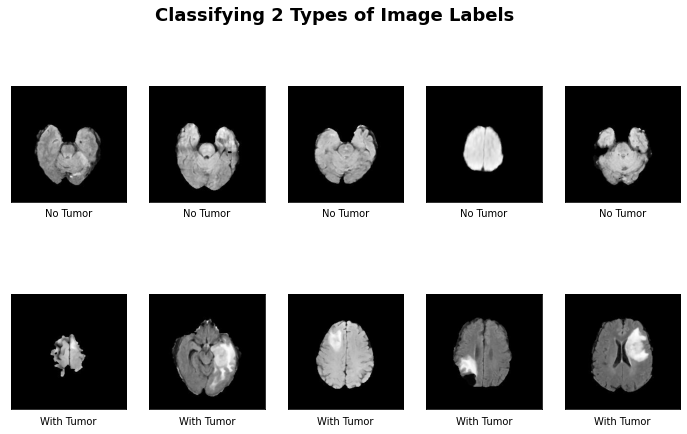

In [10]:

vis_images = vis_images[:10]
vis_labels = vis_labels[:10]

plt.figure(figsize=(12,7))
for i in range(len(vis_labels)):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    
    if vis_labels[i] == '0':
        my_label = 'No Tumor'
    elif vis_labels[i] == '1':
        my_label = 'With Tumor'
    
    plt.xlabel(my_label)
    plt.suptitle(f"Classifying 2 Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

In order to train neural networks that will be used in real-world applications, data augmentation is a crucial step. We can improve our model's ability to generalise and produce more precise predictions on data that it was not trained on by using data augmentation. <br>

Data augmentation will operate concurrently with the other layers of your application on-device and will receive GPU acceleration.

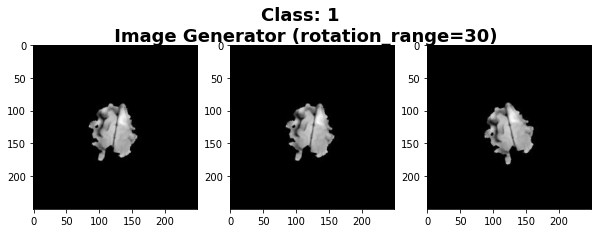

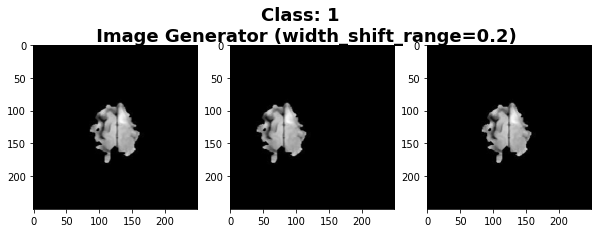

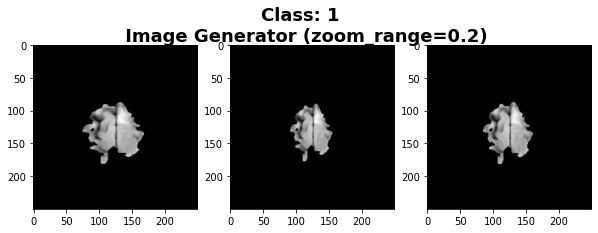

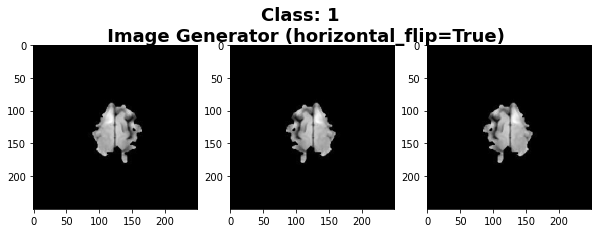

In [11]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 5)


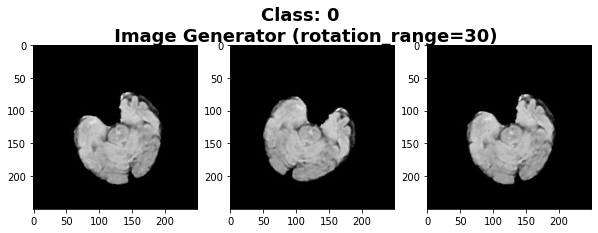

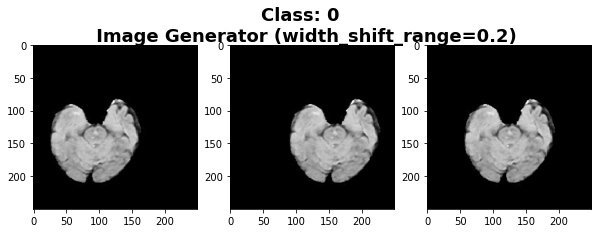

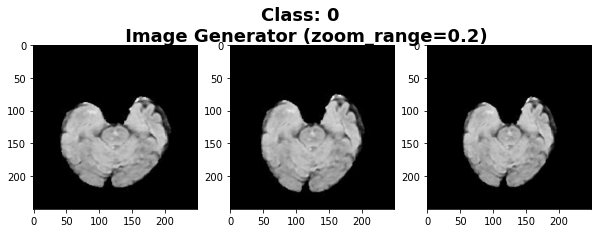

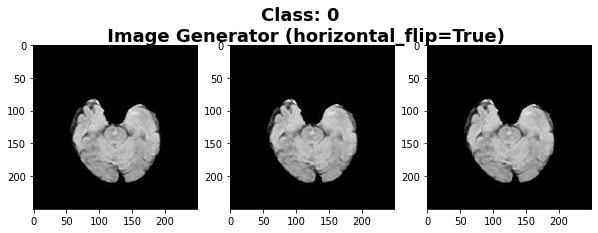

In [12]:
show_ImageDataGenerator(vis_images, vis_labels, image_index = 2)

In [13]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):

   
    train_datagen = ImageDataGenerator(rescale=1./127.5,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

   
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    
    valid_or_test_datagen = ImageDataGenerator(rescale=1./127.5)

    
    validation_generator = valid_or_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    
    test_generator = valid_or_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator, test_generator

In [14]:
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
testing_dir = os.path.join(base_dir, 'testing')

print(testing_dir)

/kaggle/working/_MODELLING/testing


In [15]:
train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, testing_dir)

Found 3009 images belonging to 2 classes.
Found 376 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
last_output = base_model.output
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")

9420800/9406464 [==============================] - 0s 0us/step
There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [17]:
def transfer_learning(last_output, pre_trained_model):
    
    x = tf.keras.layers.Flatten()(last_output)
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.6)(x)  
    
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
   
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

model = transfer_learning(last_output, base_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [18]:
model = transfer_learning(last_output, base_model)

print(f"Total Trainable Variables: {len(model.trainable_variables)}")

Total Trainable Variables: 4


This callback will stop the training when there is no improvement in
the validation loss for three consecutive epochs.

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [20]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [21]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[callback])

Epoch 1/10
95/95 [==============================] - 29s 200ms/step - loss: 1.6007 - accuracy: 0.8205 - val_loss: 1.3823 - val_accuracy: 0.7553
Epoch 2/10
95/95 [==============================] - 18s 187ms/step - loss: 0.6241 - accuracy: 0.8465 - val_loss: 0.3662 - val_accuracy: 0.8511
Epoch 3/10
95/95 [==============================] - 18s 186ms/step - loss: 0.3308 - accuracy: 0.8721 - val_loss: 0.2641 - val_accuracy: 0.9202
Epoch 4/10
95/95 [==============================] - 18s 186ms/step - loss: 0.3137 - accuracy: 0.8794 - val_loss: 0.2568 - val_accuracy: 0.9096
Epoch 5/10
95/95 [==============================] - 17s 183ms/step - loss: 0.2779 - accuracy: 0.8853 - val_loss: 0.2759 - val_accuracy: 0.8803
Epoch 6/10
95/95 [==============================] - 18s 188ms/step - loss: 0.2832 - accuracy: 0.8913 - val_loss: 0.2380 - val_accuracy: 0.9069
Epoch 7/10
95/95 [==============================] - 18s 186ms/step - loss: 0.2689 - accuracy: 0.8970 - val_loss: 0.2362 - val_accuracy: 0.9096

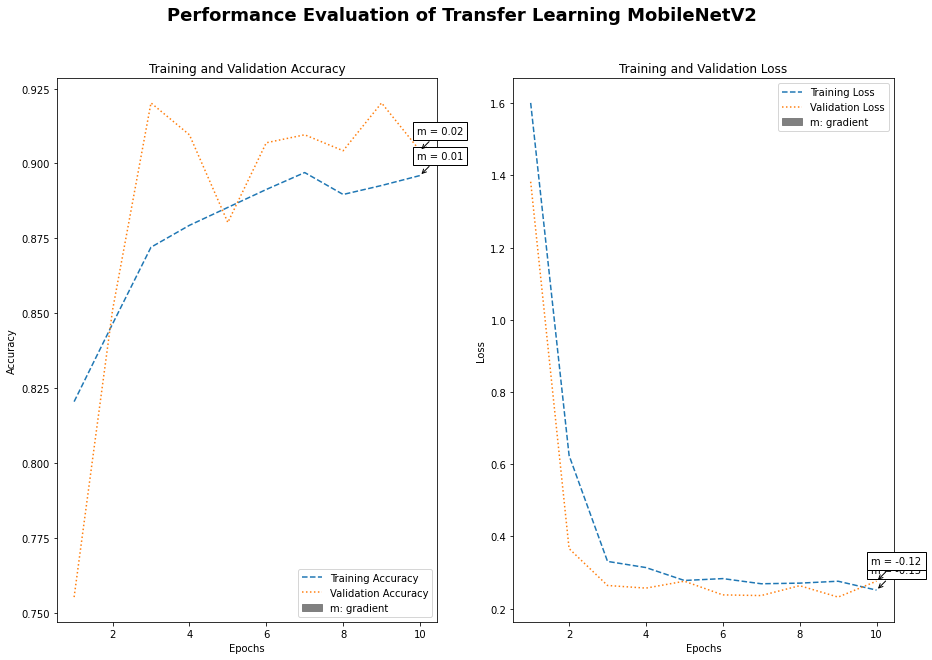

In [22]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()
    
history_dict_1 = history.history
vis_evaluation(history_dict_1, 'Transfer Learning MobileNetV2')

In [23]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
print(f"Total Trainable Variables: {len(model.trainable_variables)}")

Number of layers in the base model:  154
Total Trainable Variables: 58


In [24]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001/10),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [25]:
history_fine = model.fit(train_generator,
                         epochs=15,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

Epoch 10/15
95/95 [==============================] - 22s 196ms/step - loss: 0.5960 - accuracy: 0.8408 - val_loss: 0.2837 - val_accuracy: 0.9122
Epoch 11/15
95/95 [==============================] - 18s 188ms/step - loss: 0.3868 - accuracy: 0.8661 - val_loss: 0.2915 - val_accuracy: 0.9096
Epoch 12/15
95/95 [==============================] - 18s 187ms/step - loss: 0.3492 - accuracy: 0.8701 - val_loss: 0.2933 - val_accuracy: 0.9043
Epoch 13/15
95/95 [==============================] - 18s 185ms/step - loss: 0.3098 - accuracy: 0.8824 - val_loss: 0.3064 - val_accuracy: 0.8989
Epoch 14/15
95/95 [==============================] - 18s 184ms/step - loss: 0.2935 - accuracy: 0.8863 - val_loss: 0.2865 - val_accuracy: 0.9096
Epoch 15/15
95/95 [==============================] - 18s 185ms/step - loss: 0.2709 - accuracy: 0.8880 - val_loss: 0.2837 - val_accuracy: 0.9096


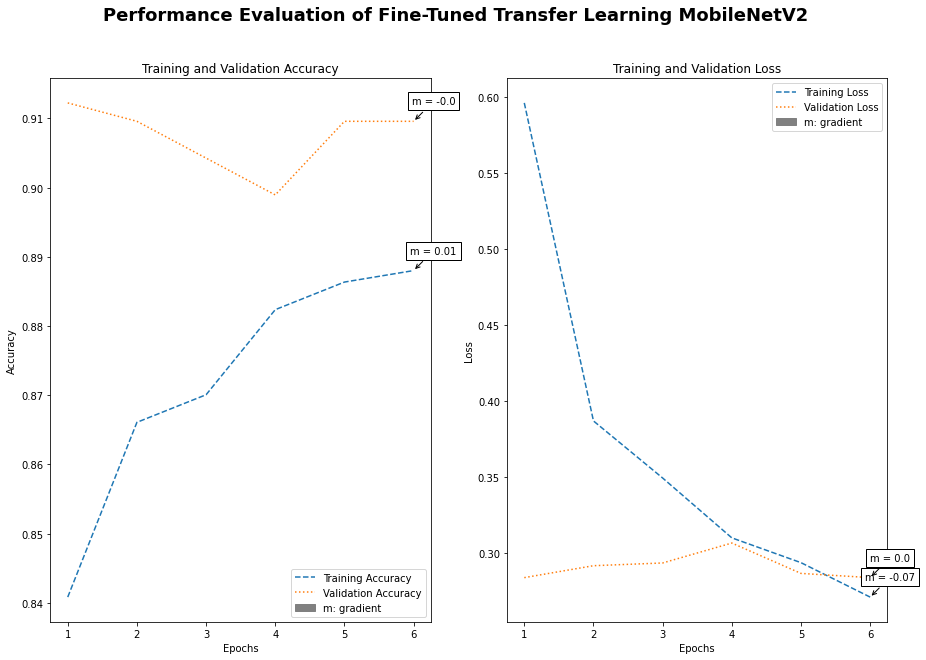

In [26]:
history_dict_2 = history_fine.history
vis_evaluation(history_dict_2, 'Fine-Tuned Transfer Learning MobileNetV2')

In [27]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

12/12 [==============================] - 1s 69ms/step - loss: 0.2596 - accuracy: 0.8806
Test accuracy : 0.8806366324424744


In [28]:
selected_paths = [] ; selected_labels = []
testing_path_0 = os.path.join(base_dir, 'testing', '0')
for x in random.sample(os.listdir(testing_path_0),10):
    selected_paths.append(os.path.join(testing_path_0, x))
    selected_labels.append(0)

testing_path_1 = os.path.join(base_dir, 'testing', '1')
for x in random.sample(os.listdir(testing_path_1),10):
    selected_paths.append(os.path.join(testing_path_1, x))
    selected_labels.append(1)

In [29]:
X, y = shuffle(selected_paths, selected_labels, random_state=0)

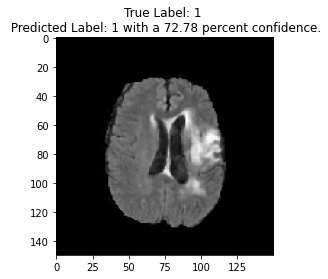

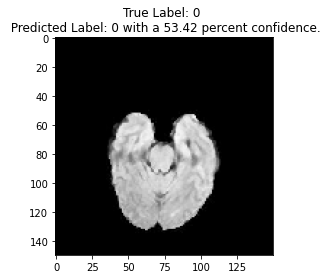

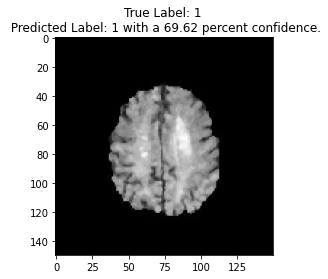

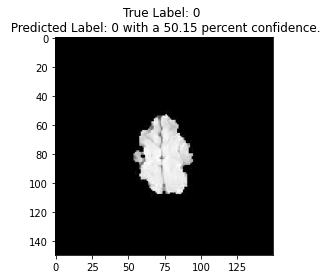

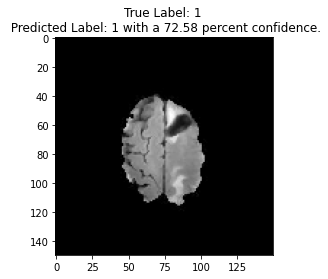

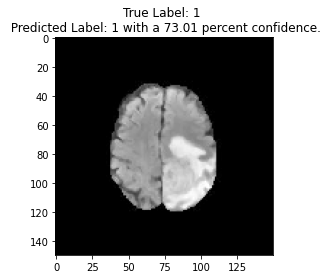

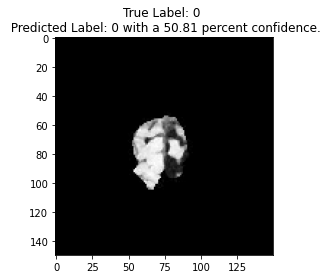

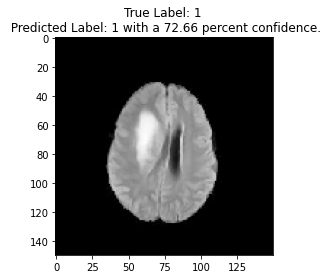

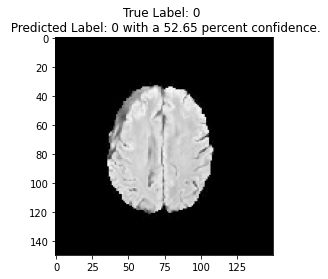

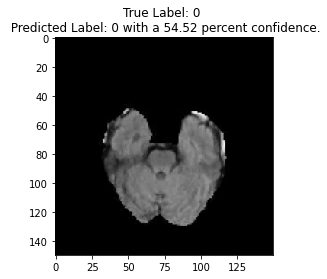

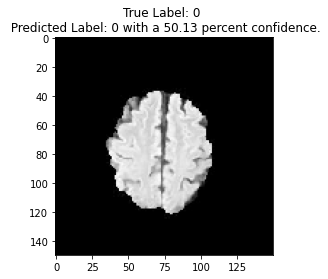

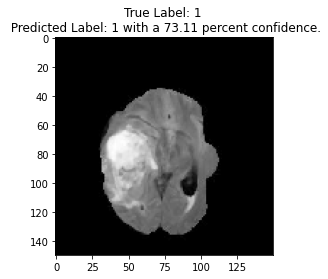

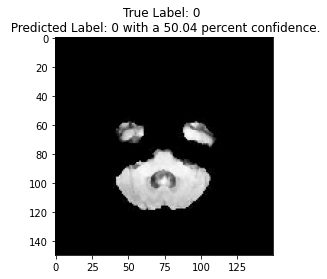

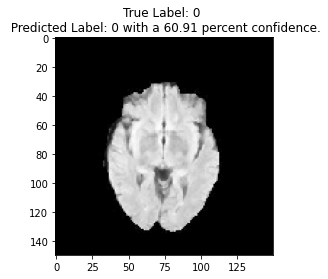

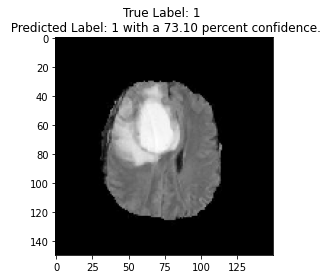

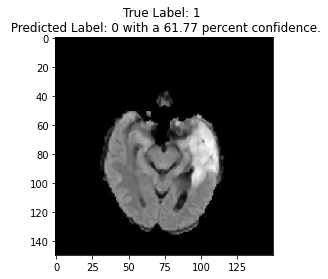

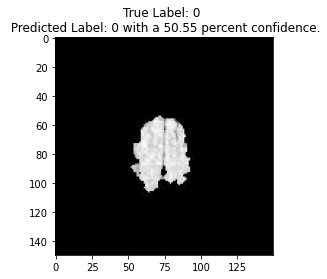

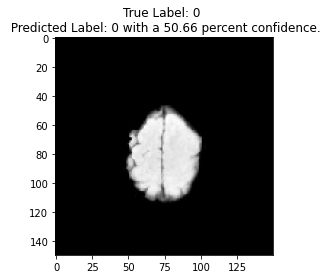

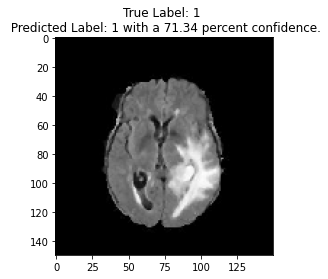

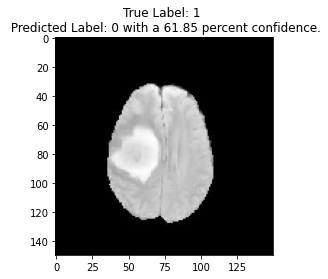

In [30]:
for vis_image, y_true in zip(X, y):
    img = image.load_img(vis_image, target_size=(150, 150))
    x = image.img_to_array(img)
    x /= 127.5
    x = np.expand_dims(x, axis=0)
    preprocess_images = np.vstack([x])
    classes = model.predict(preprocess_images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])
    if classes[0]>0.5:
        predicted_label = 1
    else:
        predicted_label =0
    plt.title(f'True Label: {y_true} \n Predicted Label: {predicted_label} with a {100 * np.max(score):.2f} percent confidence.')
    plt.imshow(img)
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


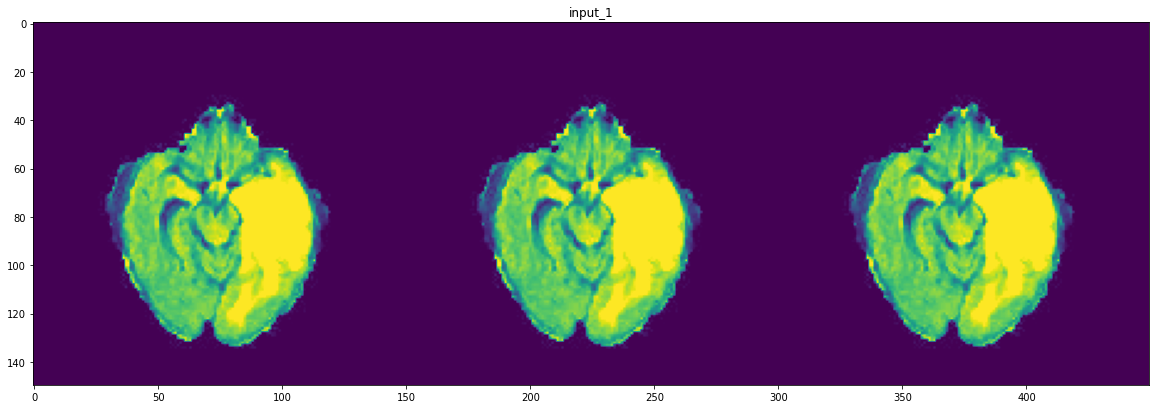

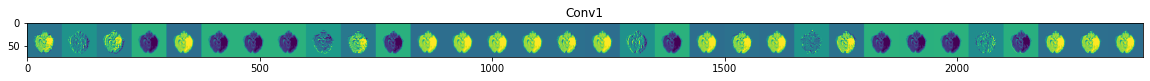

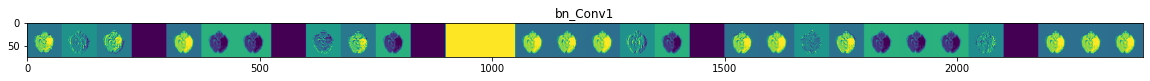

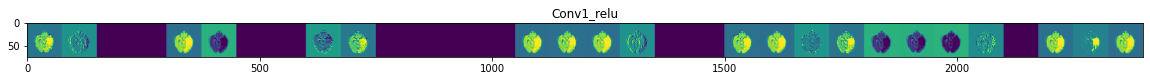

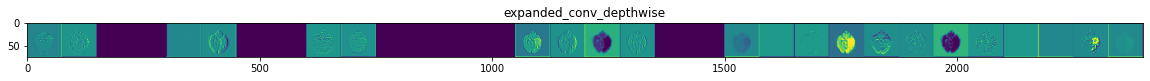

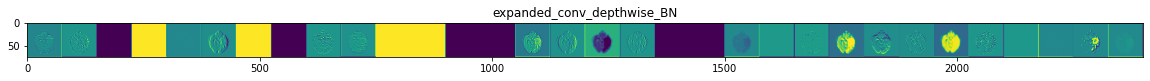

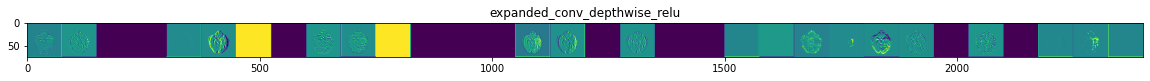

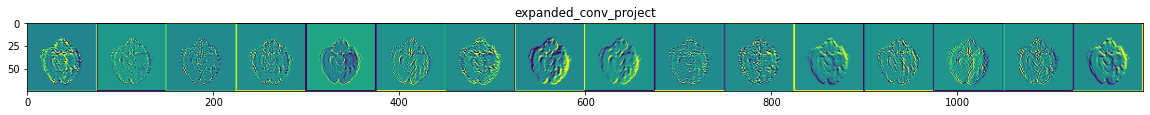

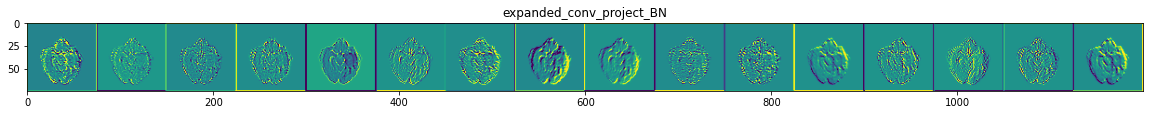

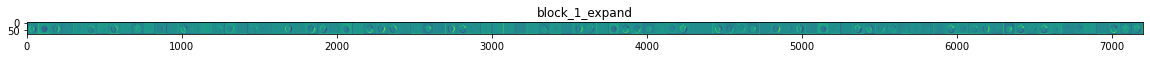

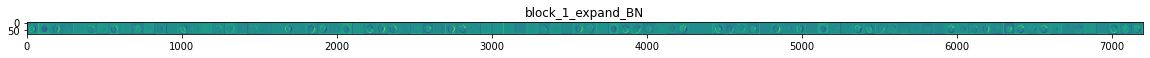

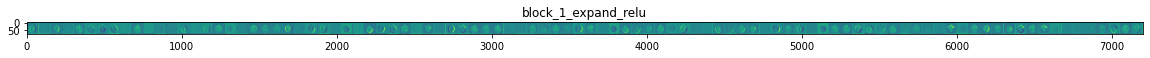

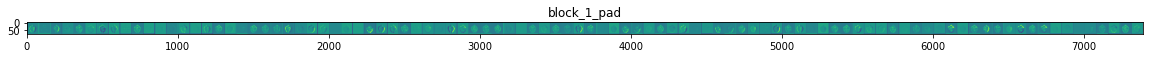

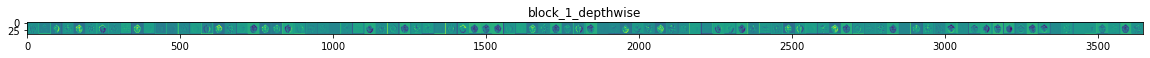

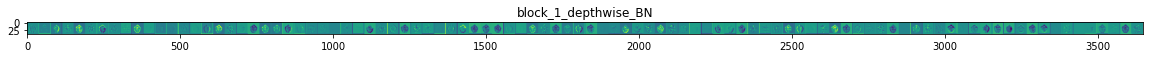

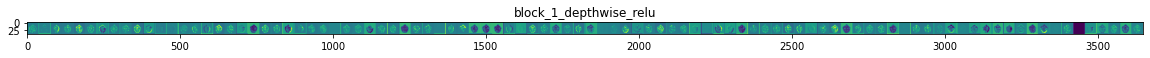

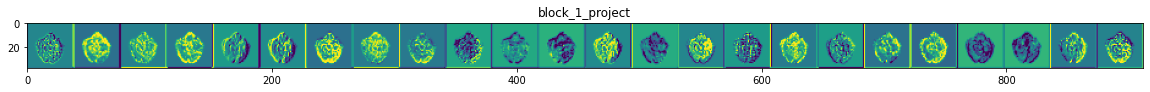

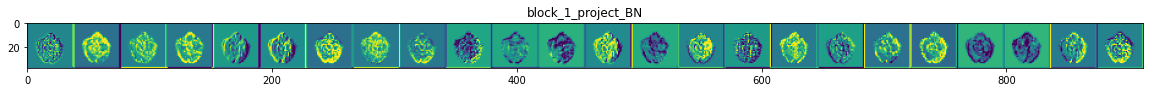

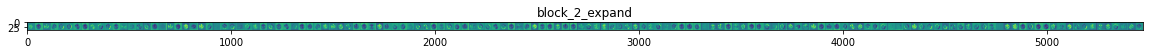

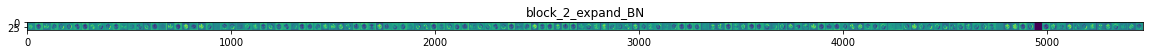

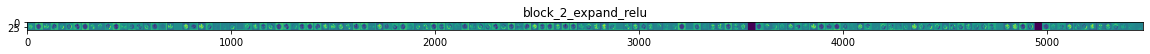

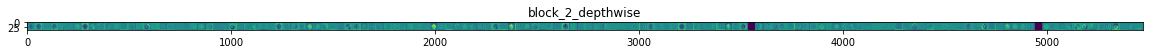

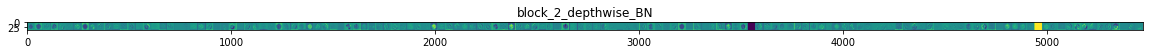

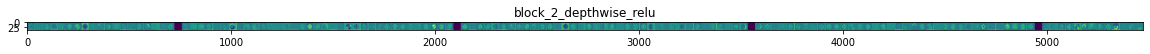

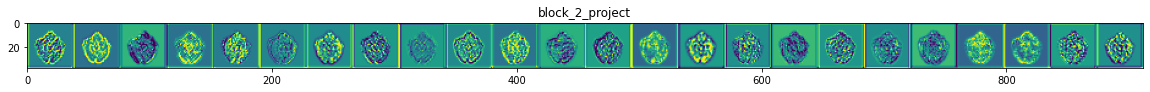

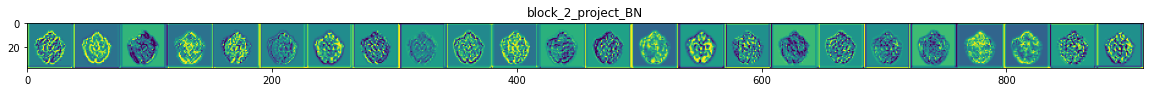

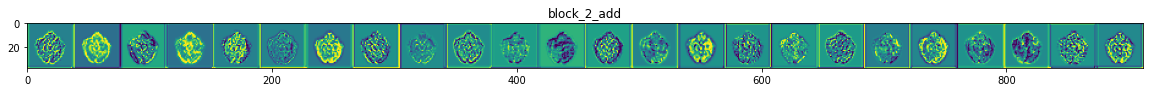

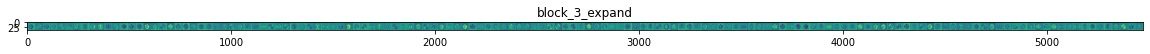

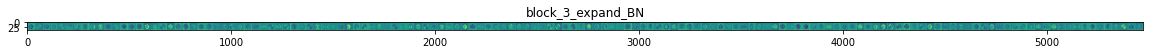

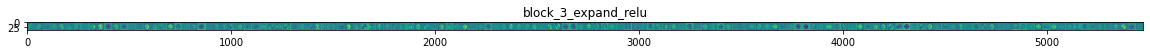

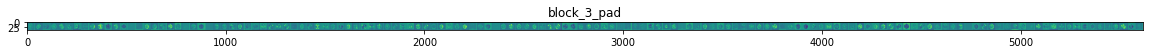

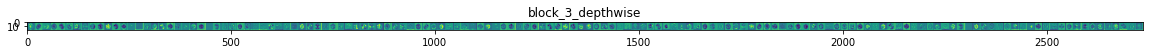

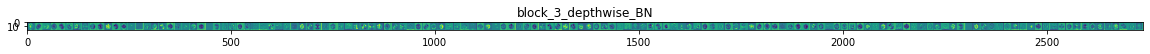

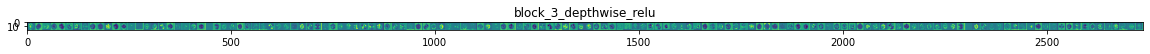

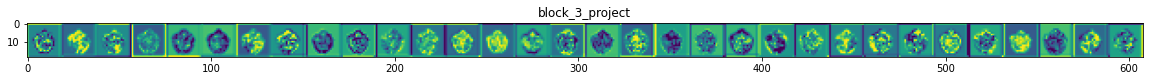

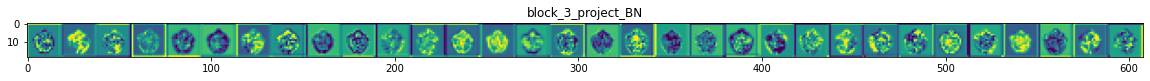

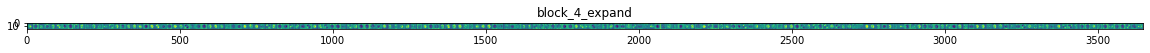

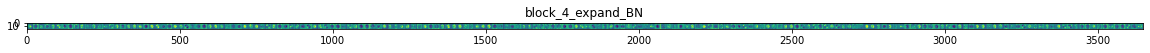

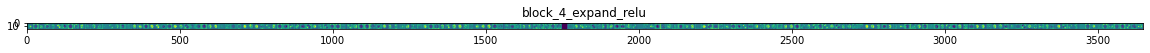

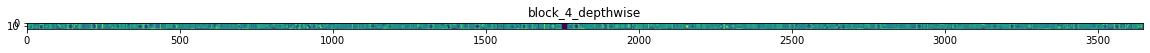

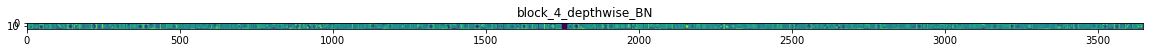

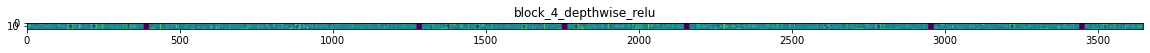

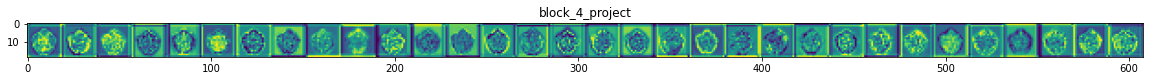

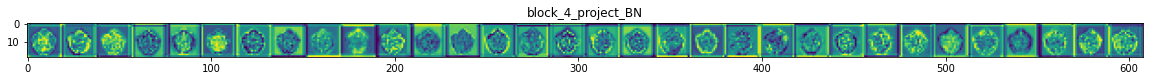

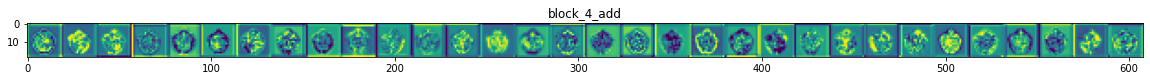

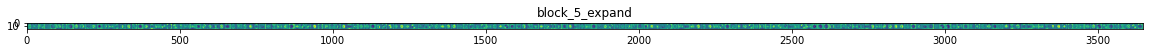

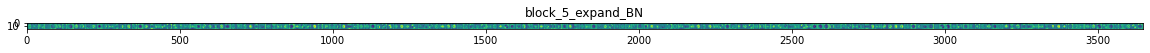

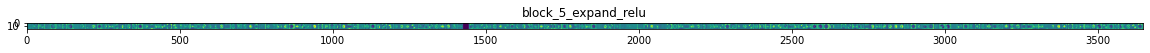

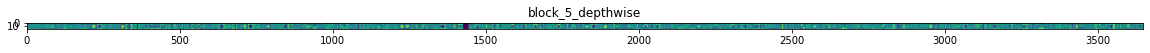

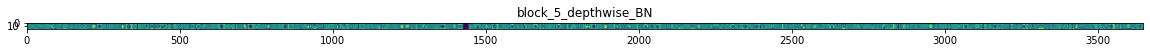

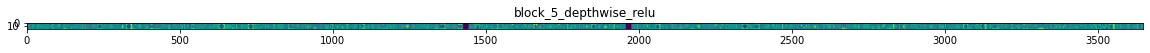

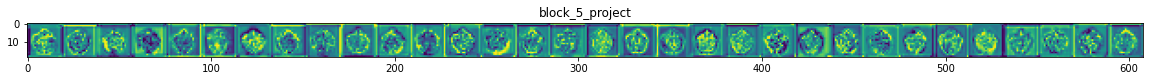

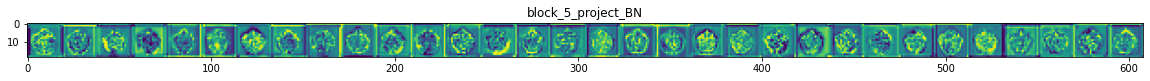

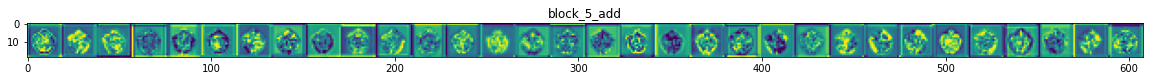

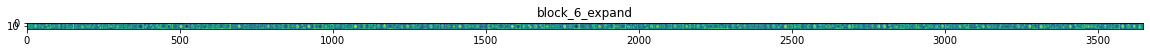

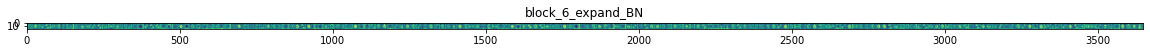

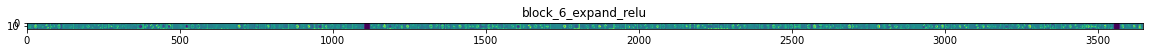

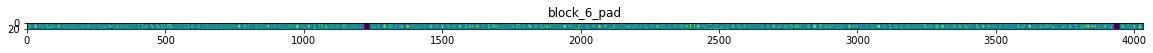

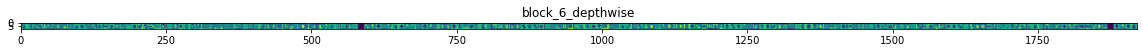

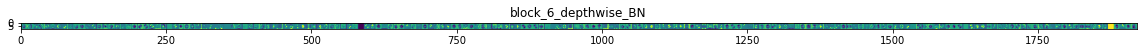

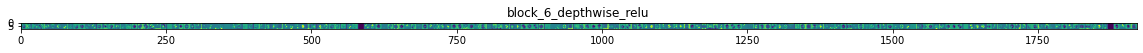

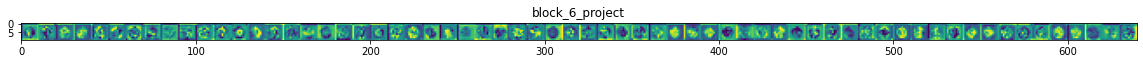

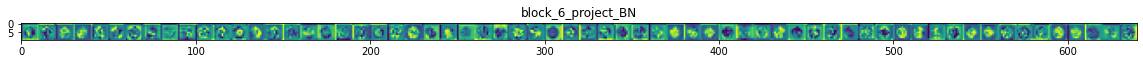

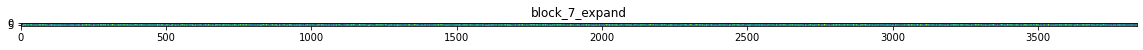

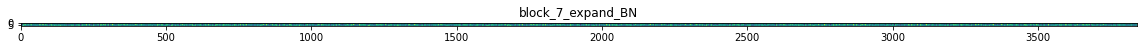

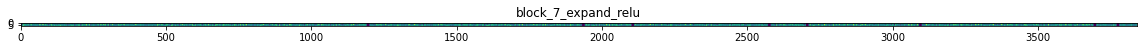

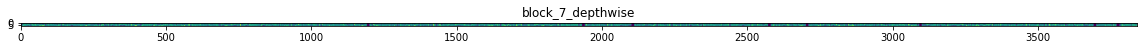

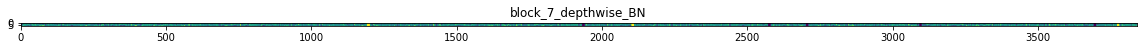

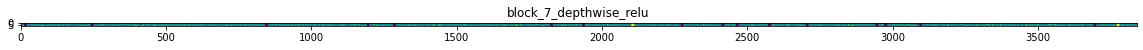

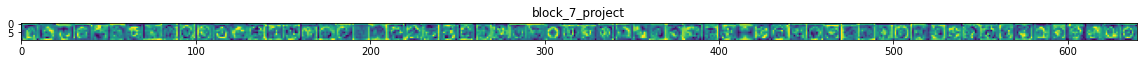

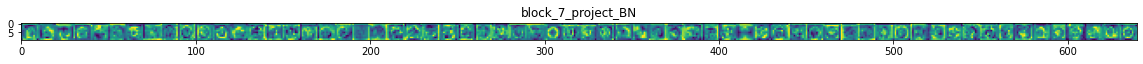

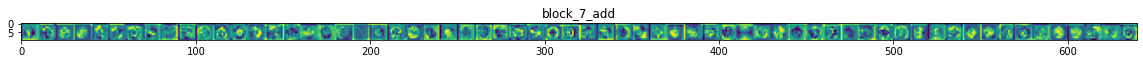

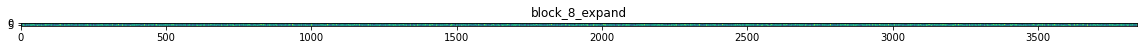

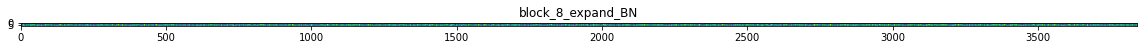

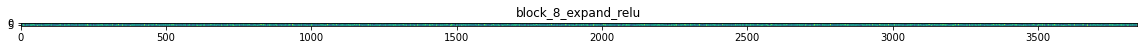

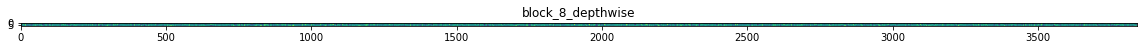

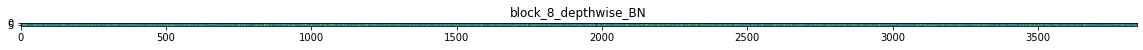

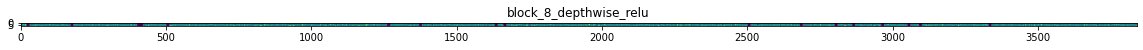

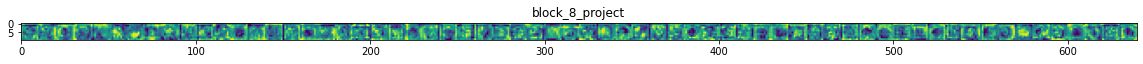

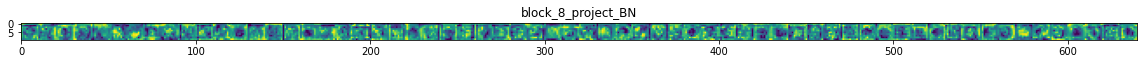

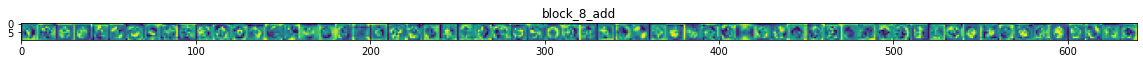

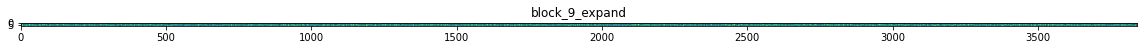

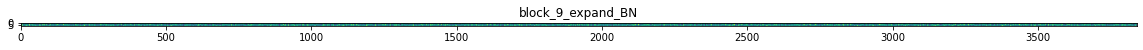

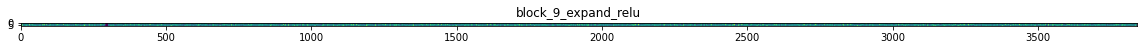

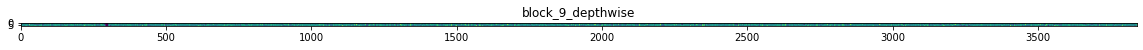

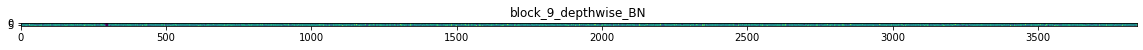

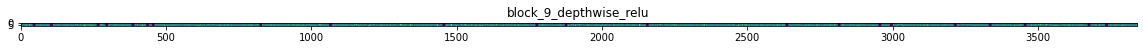

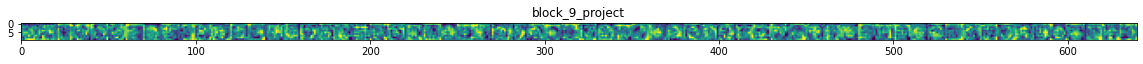

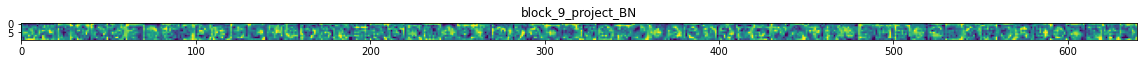

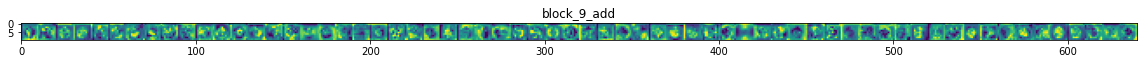

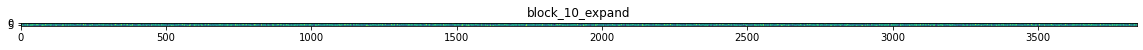

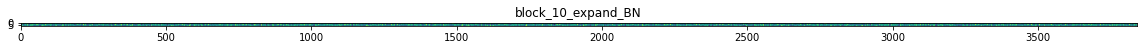

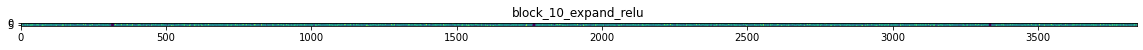

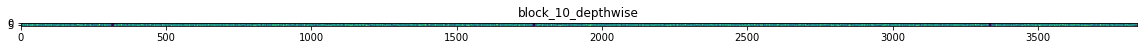

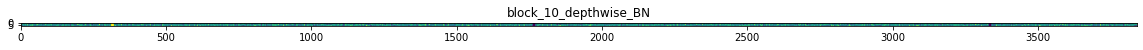

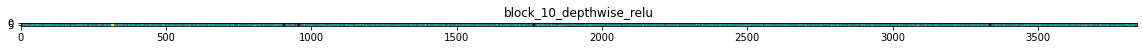

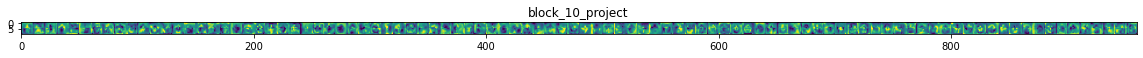

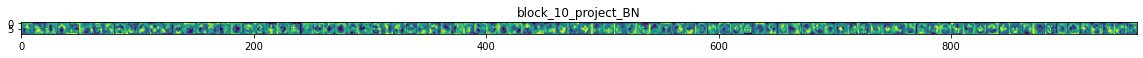

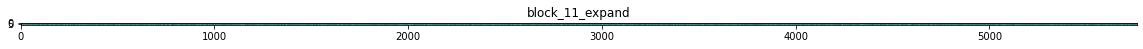

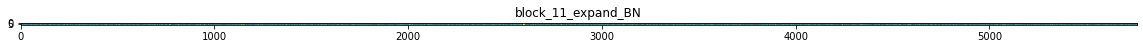

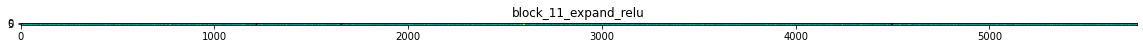

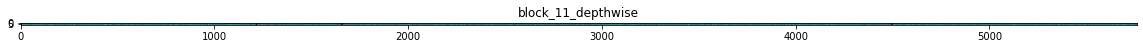

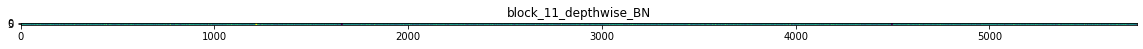

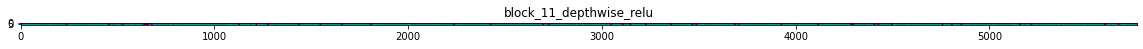

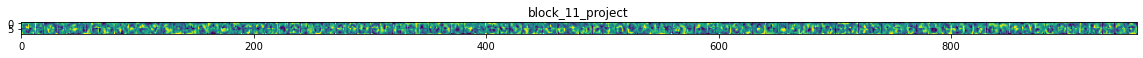

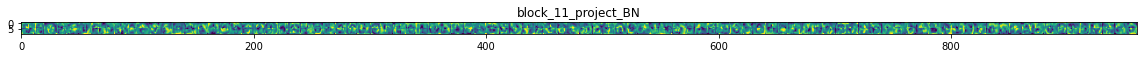

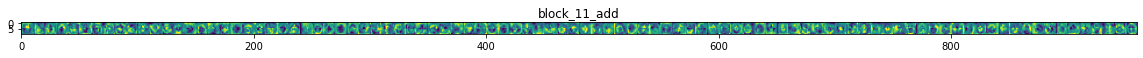

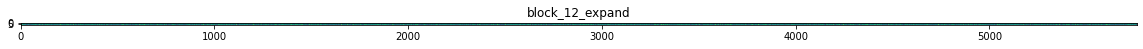

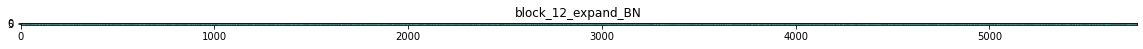

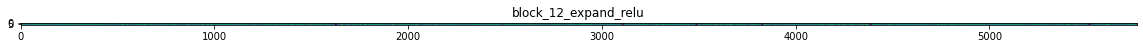

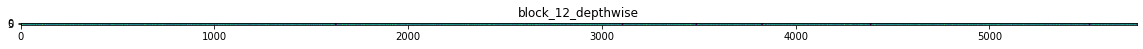

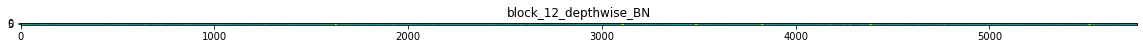

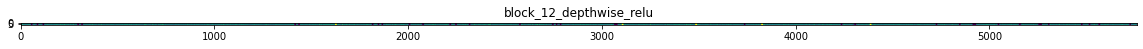

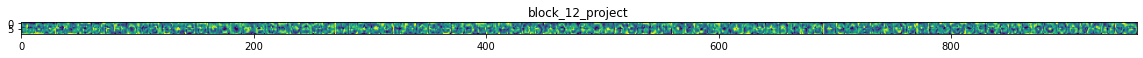

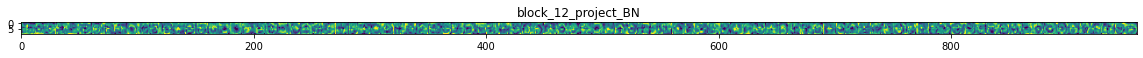

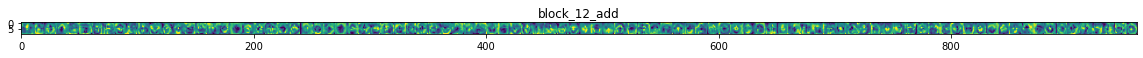

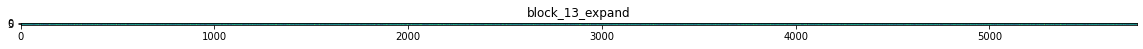

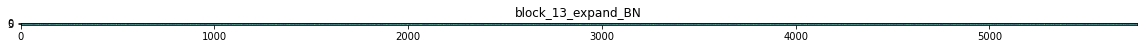

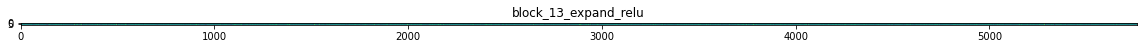

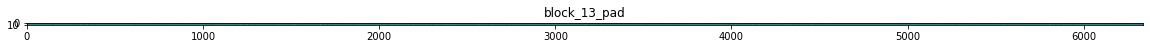

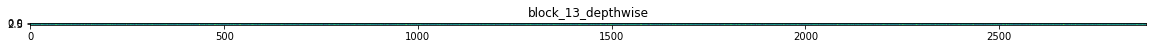

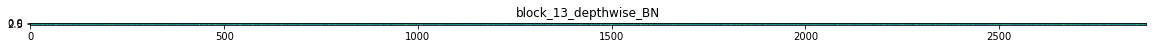

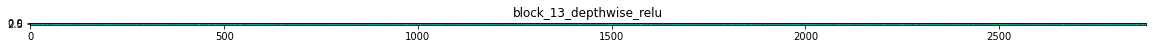

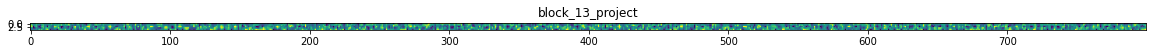

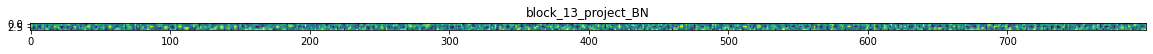

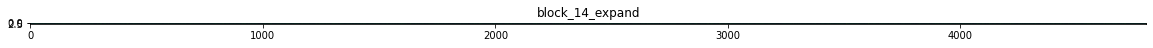

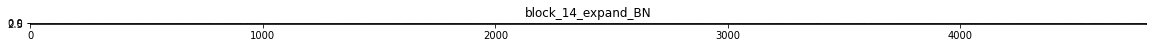

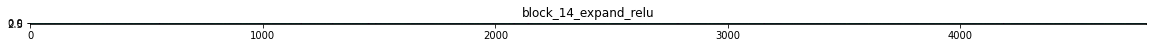

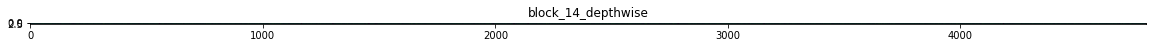

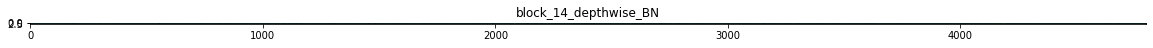

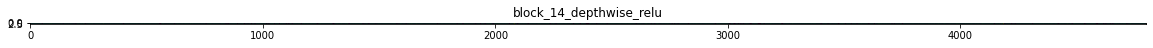

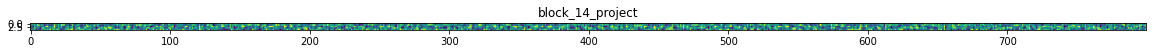

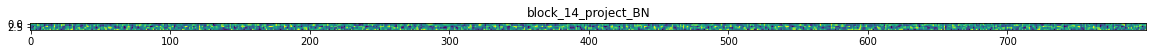

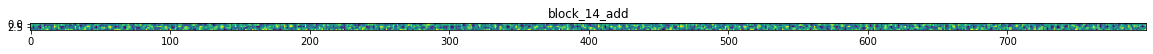

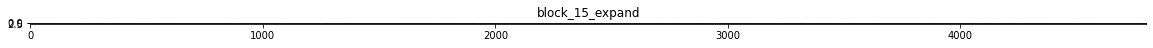

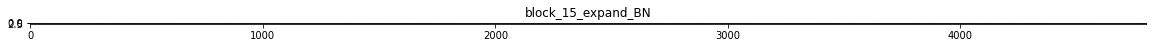

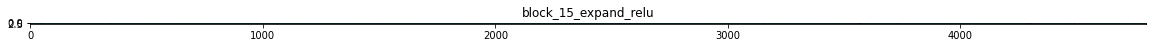

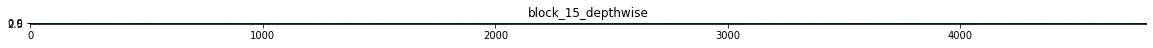

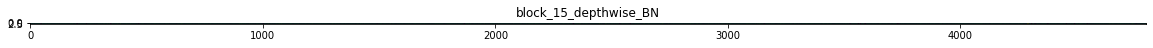

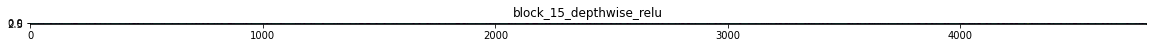

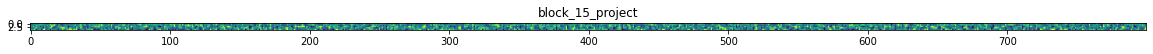

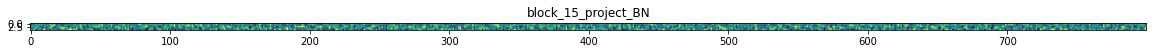

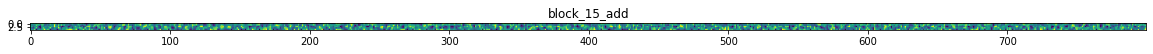

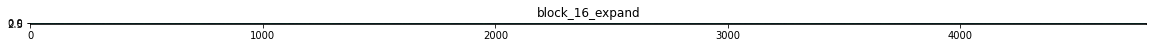

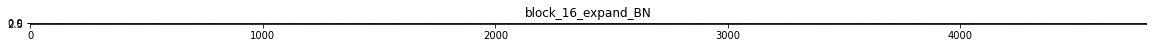

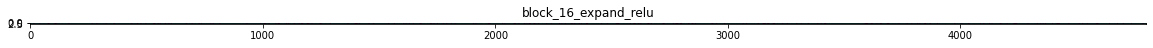

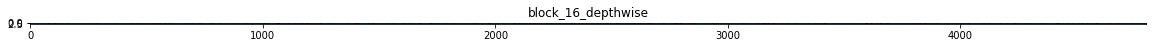

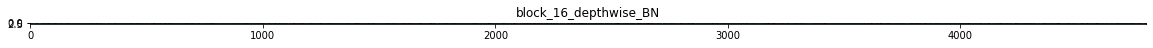

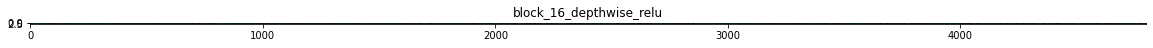

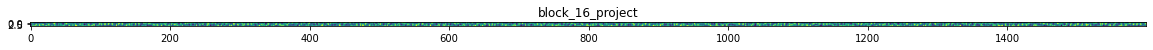

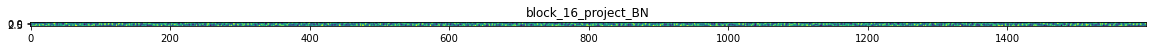

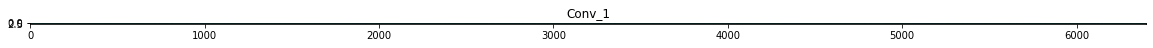

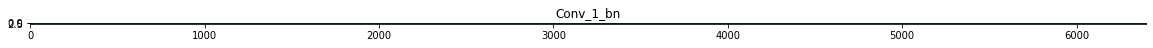

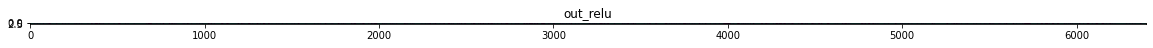

In [31]:

successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

adult_img_files = vis_images[:5]
child_img_files = vis_images[5:10]
img_path = random.choice(adult_img_files + child_img_files)
img = load_img(img_path, target_size=(150, 150))  
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                  


x /= 255.0


successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
  
    n_features = feature_map.shape[-1]  
    size       = feature_map.shape[ 1]  
    
 
    display_grid = np.zeros((size, size * n_features))
    
   
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x 

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

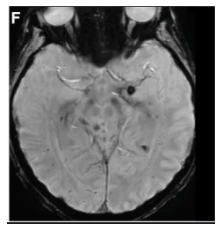

Image: /kaggle/input/mri-scanss/Screenshot 2025-02-12 235125.png
This image most likely belongs to '1' (With Tumor) at 72.87% confidence.



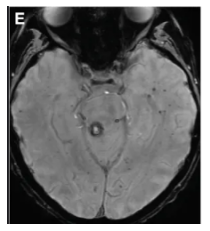

Image: /kaggle/input/mri-scanss/Screenshot 2025-02-12 235105.png
This image most likely belongs to '1' (With Tumor) at 71.09% confidence.



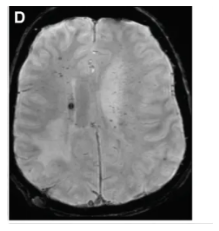

Image: /kaggle/input/mri-scanss/Screenshot 2025-02-12 235048.png
This image most likely belongs to '1' (With Tumor) at 73.06% confidence.



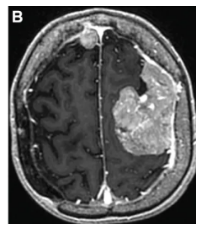

Image: /kaggle/input/mri-scanss/Screenshot 2025-02-12 234647.png
This image most likely belongs to '0' (Without Tumor) at 50.60% confidence.



In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

def make_your_prediction(image_paths=None):
    if image_paths is None:
        image_paths = ['/kaggle/input/mri-scanss/img_1.png']  
    elif isinstance(image_paths, str):
        image_paths = [image_paths] 
    
    images = []
    
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x /= 127.5
        x = np.expand_dims(x, axis=0)
        images.append(x)
        
    images = np.vstack(images)
    
    predictions = model.predict(images, batch_size=10)
    scores = tf.nn.sigmoid(predictions).numpy()
    
    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}
    
    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        if predictions[i] > 0.5:
            print(f"Image: {img_path}\nThis image most likely belongs to '{class_name_inverted[1]}' (With Tumor) at {100 * scores[i][0]:.2f}% confidence.\n")
        else:
            print(f"Image: {img_path}\nThis image most likely belongs to '{class_name_inverted[0]}' (Without Tumor) at {100 * scores[i][0]:.2f}% confidence.\n")


make_your_prediction(["/kaggle/input/mri-scanss/Screenshot 2025-02-12 235125.png", "/kaggle/input/mri-scanss/Screenshot 2025-02-12 235105.png", "/kaggle/input/mri-scanss/Screenshot 2025-02-12 235048.png", "/kaggle/input/mri-scanss/Screenshot 2025-02-12 234647.png"])